# Classification with CIFAR10 using a ResNet

## Requirements:

1. Python 2.7
3. PyTorch
2. NumPy
3. Data: download [cifar-10-python.tar.gz](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and extract as **cifar-10-python**

In [1]:
import numpy as np
import pickle
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES']='1'

### Define ResNet architecture:

In [2]:
##########################
# CNN model
##########################

class ResNetBlock(nn.Module):
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = self.downsample(x) if self.downsample is not None else x
        xnew = self.relu(self.bn1(self.conv1(x)))
        xnew = self.relu(self.bn2(self.conv2(xnew)))
        xnew = self.bn3(self.conv3(xnew))
        xnew += residual
        xnew = self.relu(xnew)
        return xnew

class ResNet(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512 * 4, 10)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * 4:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes * 4, kernel_size=1, stride=stride, bias=False),
                                       nn.BatchNorm2d(planes * 4))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * 4
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Define data loader

In [3]:
##########################
# Reading CIFAR10 data
##########################

class cifar_Loader:
    
    def __init__(self):
    
        self.train_data = None
        self.train_labels = None
        for i in range(1, 6):
            pickleFile = self.unpickle('cifar-10-batches-py/data_batch_{}'.format(i))
            dataX = pickleFile[b'data']
            dataY = pickleFile[b'labels']
            if type(self.train_data) is np.ndarray:
                self.train_data = np.concatenate((self.train_data, dataX))
                self.train_labels = np.concatenate((self.train_labels, dataY))
            else:
                self.train_data = dataX
                self.train_labels = dataY
            
        self.train_data = self.train_data.reshape(self.train_data.shape[0], 3, 32, 32)
        self.train_data = self.train_data.transpose([0, 2, 3, 1])
        
        ########################################################
        # Split train and validation via stratified sampling
        ########################################################

        np.random.seed(0)
        val_num = int(self.train_data.shape[0]*0.2)
        randord = np.random.permutation(range(self.train_data.shape[0])).tolist()
        self.val_data = self.train_data[randord[:val_num],:,:,:]
        self.val_labels = self.train_labels[randord[:val_num]]
        self.train_data = self.train_data[randord[val_num:],:,:,:]
        self.train_labels = self.train_labels[randord[val_num:]]
        
        self.test_data = None
        self.test_labels = None
        pickleFile = self.unpickle('cifar-10-batches-py/test_batch')
        dataX = pickleFile[b'data']
        dataY = pickleFile[b'labels']
        if type(self.test_data) is np.ndarray:
            self.test_data = np.concatenate((self.test_data, dataX))
            self.test_labels = np.concatenate((self.test_labels, dataY))
        else:
            self.test_data = np.array(dataX)
            self.test_labels = np.array(dataY)

        self.test_data = self.test_data.reshape(self.test_data.shape[0], 3, 32, 32)
        self.test_data = self.test_data.transpose([0, 2, 3, 1])
            
    def unpickle(self,file):
        
        with open(file, 'rb') as fo:
            dict = pickle.load(fo)
        return dict
    
class data_prepare:
    
    def __init__(self, data = None, labels = None, transform = None):        
        self.data = data  
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):        
        img, target = self.data[index], self.labels[index]
        img = np.float64(img)
        if self.transform is not None:
            img[:,:,0] -= self.transform[0][0]
            img[:,:,0] /= self.transform[0][1]
            img[:,:,1] -= self.transform[1][0]
            img[:,:,1] /= self.transform[1][1]
            img[:,:,2] -= self.transform[2][0]
            img[:,:,2] /= self.transform[2][1]
            
            if self.transform[3] == 'Augment':
                HorizontalFlip = np.random.rand(1)
                if HorizontalFlip > .5:
                    img = img[:,:,::-1].copy()
                Crop = np.random.rand(1)
                if Crop > .25:
                    img_new = np.zeros(img.shape)
                    img_tmp = img[np.random.randint(0,5):np.random.randint(28,32),
                                  np.random.randint(0,5):np.random.randint(28,32),:].copy()
                    img_new[(32-img_tmp.shape[0])/2:(32-img_tmp.shape[0])/2+img_tmp.shape[0],
                            (32-img_tmp.shape[1])/2:(32-img_tmp.shape[1])/2+img_tmp.shape[1],:]=img_tmp
                    img = img_new.copy()
                
        img = img.transpose([2, 0, 1])
        return torch.FloatTensor(img), target
    
    def __len__(self):        
        return self.data.shape[0]

### Begin loading data from CIFAR10 

In [4]:
########################################################
# Loading CIFAR10  
########################################################

cifar = cifar_Loader()

transform = []
transform.append([np.mean(cifar.train_data[:,:,:,0]), np.std(cifar.train_data[:,:,:,0])])
transform.append([np.mean(cifar.train_data[:,:,:,1]), np.std(cifar.train_data[:,:,:,1])])
transform.append([np.mean(cifar.train_data[:,:,:,2]), np.std(cifar.train_data[:,:,:,2])])

transform_train = transform + ['Augment'] # data augmentation for training images
transform_test  = transform + ['None']

# prepare training data
cifar_train = data_prepare(data = cifar.train_data, labels = cifar.train_labels, transform = transform_train)
# prepare validation data
cifar_val = data_prepare(data = cifar.val_data, labels = cifar.val_labels, transform = transform_test)
# prepare test data
cifar_test = data_prepare(data = cifar.test_data, labels = cifar.test_labels, transform = transform_test)

print("training data: {}".format(cifar_train.data.shape))
print("training label: {}".format(cifar_train.labels.shape))
print("validation data: {}".format(cifar_val.data.shape))
print("validation label: {}".format(cifar_val.labels.shape))
print("test data: {}".format(cifar_test.data.shape))
print("test label: {}".format(cifar_test.labels.shape))

training data: (40000, 32, 32, 3)
training label: (40000,)
validation data: (10000, 32, 32, 3)
validation label: (10000,)
test data: (10000, 32, 32, 3)
test label: (10000,)


### Begin training

In [5]:
# Hyperparameters
n_epochs = 50
n_verbose = 2
batch_size = 200
learning_rate = 0.001
weight_decay=1e-4

# Define Model
model = ResNet(ResNetBlock, [3, 4, 6, 3])
model = model.cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Prepare data loader
loader_train = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = torch.utils.data.DataLoader(cifar_val, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True, num_workers=2)

print model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): ResNetBlock(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [6]:
# Begin iteration

LOSS_train = np.zeros(n_epochs)
LOSS_val = np.zeros(n_epochs)
ACC_train = np.zeros(n_epochs)
ACC_val = np.zeros(n_epochs)
history_loss_best = 10**6
history_tolerance = 0
best_epoch = 0

for epoch in range(n_epochs): 
     
    # training
    loss_train = []
    correct = 0
    total = 0
    for data in loader_train:
        # prepare data in minibatch
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        images, labels_var = Variable(images), Variable(labels)
        
        # Train on minibatch: initialize grad. - forward - loss - backward - update grad.
        optimizer.zero_grad()              
        outputs = model(images)            
        loss = criterion(outputs, labels_var)  
        loss.backward()                    
        optimizer.step()                  
        
        loss_train.append(loss.data[0])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    LOSS_train[epoch] = sum(loss_train)/len(loss_train)
    ACC_train[epoch] = correct * 100./ total
        
    # validation
    loss_val = []
    correct = 0
    total = 0
    for data in loader_val:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        images, labels_var = Variable(images), Variable(labels)
        outputs = model(images)
        loss = criterion(outputs, labels_var)        
        loss_val.append(loss.data[0])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    LOSS_val[epoch] = sum(loss_val)/len(loss_val)
    ACC_val[epoch] = correct * 100./ total
    
    if epoch > 20 and LOSS_val[epoch] < history_loss_best and history_tolerance <= 10:
        torch.save(model.state_dict(), './model_1.1.pt')
        history_loss_best = LOSS_val[epoch] 
        history_tolerance = 0
        best_epoch = epoch
        
        print("Epoch {} Train loss {:.2f} accuracy {:.2f}% | Validation loss {:.2f} accuracy {:.2f}% best model!".format(
            epoch, LOSS_train[epoch], ACC_train[epoch], LOSS_val[epoch], ACC_val[epoch]))        
    else:
        if epoch > 20:
            history_tolerance += 1
        
        if epoch % n_verbose == 0:
            print("Epoch {} Train loss {:.2f} accuracy {:.2f}% | Validation loss {:.2f} accuracy {:.2f}% ".format(
            epoch, LOSS_train[epoch], ACC_train[epoch], LOSS_val[epoch], ACC_val[epoch]))

print("Best model detected at epoch {}".format(best_epoch))

Epoch 0 Train loss 1.72 accuracy 39.04% | Validation loss 1.34 accuracy 51.91% 
Epoch 2 Train loss 0.95 accuracy 66.67% | Validation loss 0.86 accuracy 69.52% 
Epoch 4 Train loss 0.65 accuracy 77.50% | Validation loss 0.65 accuracy 77.27% 
Epoch 6 Train loss 0.53 accuracy 81.64% | Validation loss 0.60 accuracy 79.81% 
Epoch 8 Train loss 0.44 accuracy 84.63% | Validation loss 0.52 accuracy 82.49% 
Epoch 10 Train loss 0.38 accuracy 86.63% | Validation loss 0.50 accuracy 83.48% 
Epoch 12 Train loss 0.34 accuracy 88.18% | Validation loss 0.47 accuracy 84.41% 
Epoch 14 Train loss 0.31 accuracy 89.21% | Validation loss 0.48 accuracy 84.39% 
Epoch 16 Train loss 0.27 accuracy 90.70% | Validation loss 0.46 accuracy 84.86% 
Epoch 18 Train loss 0.24 accuracy 91.49% | Validation loss 0.47 accuracy 84.56% 
Epoch 20 Train loss 0.23 accuracy 91.96% | Validation loss 0.45 accuracy 85.58% 
Epoch 21 Train loss 0.22 accuracy 92.32% | Validation loss 0.46 accuracy 85.25% best model!
Epoch 22 Train loss 0.

### Plot training vs. validation loss and accuracy

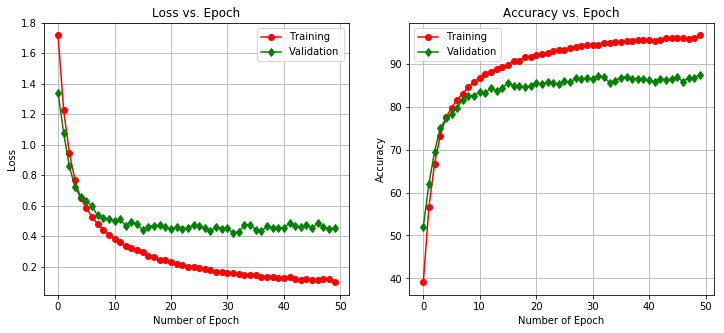

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(range(n_epochs), LOSS_train, 'ro-', label='Training')
plt.plot(range(n_epochs), LOSS_val, 'gd-', label='Validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(range(n_epochs), ACC_train, 'ro-', label='Training')
plt.plot(range(n_epochs), ACC_val, 'gd-', label='Validation')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

### Test result

In [8]:
# test
model.load_state_dict(torch.load('./model_1.1.pt'))
loss_test = []
correct = 0
total = 0
for data in loader_test:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    images, labels_var = Variable(images), Variable(labels)
    outputs = model(images)
    loss = criterion(outputs, labels_var)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    loss_test.append(loss.data[0])

print("Test loss = {}".format(sum(loss_test)/len(loss_test)))
print("Test accuracy = {:.2f}%".format(correct * 100./ total))

Test loss = 0.451064198613
Test accuracy = 86.23%
